In [1]:
from bitorch.quantizations.quantization_scheduler import MixLinearScheduling, StepScheduling
import torch
from torch.nn import Tanh, ReLU
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
from typing import List, Callable

from bitorch.quantizations import (
    Sign,
    SwishSign,
    SteHeaviside,
    ApproxSign,
    ProgressiveSign,
    InputDoReFa,
    WeightDoReFa,
    Identity,
)
from bitorch.layers import QActivation
import numpy as np

/home/paul/uni/deeplearning/bitorch/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Quantization Visualization

Use the code below to visualize the quantization functions supported in bitorch. The upper graph shows the applied quantization during forward pass (black graph) as well as the integral of the backward pass function (red). The graph below shows the function applied during backward pass.

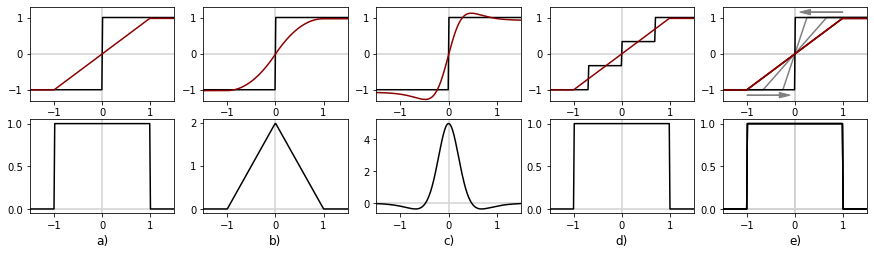

In [2]:
LABEL_POS = -0.4


def calculate_numeric_gradient(x_values: np.array, y_values: np.array, x_step_size: float):
    # :param x_values: a list of equidistant x values
    # :param y_values: the list of corresponding y values for an unknown function
    # :param x_step_size: the fixed distance between two consecutive x values
    # :return: a list of numeric gradients for each step in the function (with one less element than the given x_values)

    # initialize a numpy array with the correct size
    numeric_gradient = np.zeros(len(x_values) - 1)

    for i in range(1, len(x_values)):
        numeric_gradient[i - 1] = (y_values[i] - y_values[i - 1]) / x_step_size
    return numeric_gradient


def reconstruct_gradient_function(x_grad_values: np.array, x_step_size: float, y_offset=0.0):
    # :param x_grad_values: a list of calculated gradients (based on step size `x_step_size`)
    # :param x_step_size: the distance between two consecutive x values that was used to calculate `x_grad_values`
    # :return: a list of y values for a (representative) function that would create the given gradient values
    #          (the y_values should be zero at the middle element)

    # intialize an array with the correct size
    y_values = np.zeros(len(x_grad_values))

    y_values[0] = 0
    for i in range(1, len(x_grad_values)):
        y_values[i] = y_values[i - 1] + x_grad_values[i] * x_step_size
    y_values -= y_values[len(x_grad_values) // 2]
    y_values += y_offset
    return y_values


def plot_functions(
    functions_to_plot: List[Callable[[torch.tensor], torch.tensor]],
    xlim=(-1.5, 1.5),
    ylim=(-1.5, 1.5),
    steps=200,
    y_offset=0.0,
):
    x_values = np.linspace(*xlim, steps)
    x_step_size = (xlim[1] - xlim[0]) / steps

    fig, axes = plt.subplots(2, len(functions_to_plot) + 1, figsize=FIGSIZE, subplot_kw={"xlim": xlim})

    if len(functions_to_plot) == 1:
        axes = [axes]
    # create the actual plot
    for fn, axis_idx in zip(functions_to_plot, range(len(functions_to_plot))):
        x = torch.tensor(x_values, requires_grad=True, dtype=torch.float)
        y = fn(x)
        y.sum().backward()

        y_values = y.detach().numpy()

        numeric_gradient = calculate_numeric_gradient(x_values, y_values, x_step_size)
        numeric_grad_function = reconstruct_gradient_function(x.grad, x_step_size, y_offset=y_offset)
        axes[0][axis_idx].locator_params(tight=True, nbins=3)
        axes[1][axis_idx].locator_params(tight=True, nbins=3)
        axes[0][axis_idx].set_ylim((-1.3, 1.3))

        axes[0][axis_idx].plot(x_values, y_values, color="black")
        axes[1][axis_idx].plot(x_values, x.grad, color="black")
        axes[0][axis_idx].plot(x_values, numeric_grad_function, color="darkred")
        axes[1][axis_idx].set_title(str(chr(ord("a") + axis_idx)) + ")", y=LABEL_POS)

        for axis in axes[:, axis_idx]:
            axis.axvline(x=0, c="lightgrey", zorder=0)
            axis.axhline(y=0, c="lightgrey", zorder=0)

    # plt.show()
    return len(functions_to_plot), axes


def plot_progressive(
    axes,
    idx,
    functions_to_plot: List[Callable[[torch.tensor], torch.tensor]],
    xlim=(-1.5, 1.5),
    ylim=(-1.5, 1.5),
    steps=200,
    y_offset=0.0,
):
    x_values = np.linspace(*xlim, steps)
    x_step_size = (xlim[1] - xlim[0]) / steps
    first = True
    for fi, fn in enumerate(functions_to_plot):
        fn.training = True
        x = torch.tensor(x_values, requires_grad=True, dtype=torch.float)
        y = fn(x)
        y.sum().backward()
        c = "grey"
        if fi == len(functions_to_plot) - 1:
            first = False
            c = "black"

        y_values = y.detach().numpy()

        numeric_gradient = calculate_numeric_gradient(x_values, y_values, x_step_size)
        numeric_grad_function = reconstruct_gradient_function(x.grad, x_step_size, y_offset=y_offset)
        axes[0][idx].locator_params(tight=True, nbins=3)
        axes[1][idx].locator_params(tight=True, nbins=3)
        axes[0][idx].set_ylim((-1.3, 1.3))

        axes[0][idx].plot(x_values, y_values, color=c)
        axes[1][idx].plot(x_values, x.grad, color="black")
        axes[0][idx].plot(x_values, numeric_grad_function, color="darkred")
        axes[1][idx].set_title(str(chr(ord("a") + idx)) + ")", y=LABEL_POS)

        for axis in axes[:, idx]:
            axis.axvline(x=0, c="lightgrey", zorder=0)
            axis.axhline(y=0, c="lightgrey", zorder=0)


def quantize(x: torch.tensor):
    backward = x.clip(-1, 1)
    forward = (x.clip(-1, 1) * 3).round() / 3
    return (forward - backward).detach() + backward


FIGSIZE = (15, 3.8)
LABEL_POS = -0.4

# plot_functions([quantize])
idx, axes = plot_functions(
    [
        QActivation(Sign(), 1.0),
        ApproxSign(),
        SwishSign(),
        QActivation(WeightDoReFa(2)),
    ]
)
plot_progressive(
    axes, idx, [QActivation(ProgressiveSign(use_global_scaling=False, initial_scale=i), 1.0) for i in [0.03, 0.1, 1.0]]
)
axes[0][idx].arrow(1.0, 1.15, -0.9, 0.0, head_width=0.15, length_includes_head=True, color="grey")
axes[0][idx].arrow(-1.0, -1.15, 0.9, 0.0, head_width=0.15, length_includes_head=True, color="grey")
plt.savefig("quantization_functions.pdf", dpi=600, bbox_inches="tight")
plt.show()

# Quantization scheduling visualization

Use the code below to visualize the scheduling of quantizations. You can replace the used quantization functions and observe how they are applied with different factors.

### 

In [23]:
steps = 100
factor_samples = 5
function_samples = 300


FIGURE_SIZE = (8, 10)
LABEL_POS = -0.3
xlim = (-1.5, 1.5)
ylim = (-1.3, 1.3)


def sample_scheduler(i, axes, scheduler):
    axes[0].clear()
    axes[1].clear()

    x_values = np.linspace(*xlim, steps)
    x_step_size = (xlim[1] - xlim[0]) / steps
    scheduler.factor = i / steps if i <= steps else 1.0 - ((i - steps) / steps)
    x = torch.tensor(x_values, requires_grad=True, dtype=torch.float)
    y = scheduler(x)
    y.sum().backward()

    y_values = y.detach().numpy()

    numeric_gradient = calculate_numeric_gradient(x_values, y_values, x_step_size)
    numeric_grad_function = reconstruct_gradient_function(x.grad, x_step_size, y_offset=0.0)
    axes[0].locator_params(tight=True, nbins=3)
    axes[1].locator_params(tight=True, nbins=3)
    axes[0].set_ylim((-1.3, 1.3))

    axes[0].plot(x_values, y_values, color="black")
    axes[1].plot(x_values, x.grad, color="black")
    axes[0].plot(x_values, numeric_grad_function, color="darkred")
    axes[1].set_title(f"factor: {scheduler.factor:.2f}", y=LABEL_POS)

    for axis in axes:
        axis.axvline(x=0, c="lightgrey", zorder=0)
        axis.axhline(y=0, c="lightgrey", zorder=0)

In [24]:
scheduler = MixLinearScheduling(
    [Identity(), Tanh(), Sign(), InputDoReFa(2), InputDoReFa(4), InputDoReFa(8), ReLU()], steps
)
fig, ax = plt.subplots(2, 1, figsize=FIGURE_SIZE)
anim_created = FuncAnimation(fig, sample_scheduler, frames=2 * steps, interval=50, fargs=(ax, scheduler))

video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

plt.close()

In [25]:
scheduler = StepScheduling([Identity(), Tanh(), Sign(), InputDoReFa(2), InputDoReFa(4), InputDoReFa(8), ReLU()], steps)
fig, ax = plt.subplots(2, 1, figsize=FIGURE_SIZE)
anim_created = FuncAnimation(fig, sample_scheduler, frames=2 * steps, interval=50, fargs=(ax, scheduler))

video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)

plt.close()